In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import json
import os
import torchvision
import torchvision.transforms as transforms
from math import ceil
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## Dataset and Dataloader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
epochs = 100
lr = 0.001
split_size = 0.9

path_to_anns = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\annotations\\all_data.json"
path_to_img = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\images"

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.float32)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"])
        keypoints = keypoints * [224 / orig_width, 224 / orig_height]
        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(keypoints)

dataset = FlickrDataset(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset) * split_size)
val_len = ceil(len(dataset) * (1-split_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (train_len, val_len))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Create Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm = nn.BatchNorm2d(5)
        self.linear1 = nn.LazyLinear(1000)
        self.linear2 = nn.Linear(1000, 136)

    def forward(self, x):
        x = self.norm(self.pool(F.relu(self.conv(x))))
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

## Train loop

In [ ]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []

for epoch in range(epochs):
    train_running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        image, keypoints = data[0].to(device), data[1].to(device)
        preds = model(image)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / batch_size))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')

## Plot loss

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
epochs = 100
lr = 0.001
split_size = 0.9

path_to_anns = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\annotations\\all_data.json"
path_to_img = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\images"

In [3]:
class FlickrDataset(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.float32)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"])
        keypoints = keypoints * [224 / orig_width, 224 / orig_height]
        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(keypoints)

dataset = FlickrDataset(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset) * split_size)
val_len = ceil(len(dataset) * (1-split_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (train_len, val_len))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Create Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm = nn.BatchNorm2d(5)
        self.linear1 = nn.LazyLinear(1000)
        self.linear2 = nn.Linear(1000, 136)

    def forward(self, x):
        x = self.norm(self.pool(F.relu(self.conv(x))))
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

## Train loop

In [5]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []

for epoch in range(epochs):
    train_running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        image, keypoints = data[0].to(device), data[1].to(device)
        preds = model(image)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
            image, keypoints = data[0].to(device), data[1].to(device)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / ceil(len(val_dataset) / batch_size))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')
    print(f'Val_loss at epoch {epoch + 1}: {val_loss[-1]}')

C:\Users\user\anaconda3\envs\pytorch_tutorial\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch: 1
Train_loss at epoch 1: 55.62786039033586
Val_loss at epoch 1: 26.268909621480887


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 2
Train_loss at epoch 2: 20.487881717766342
Val_loss at epoch 2: 17.115842729881706


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 3
Train_loss at epoch 3: 12.959861190255772
Val_loss at epoch 3: 16.25914423501596


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 4
Train_loss at epoch 4: 9.217484818411785
Val_loss at epoch 4: 13.102586612917747


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 5
Train_loss at epoch 5: 8.123848803408354
Val_loss at epoch 5: 13.219325098217201


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 6
Train_loss at epoch 6: 7.090980354970167
Val_loss at epoch 6: 12.476384138118124


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 7
Train_loss at epoch 7: 5.905793760878492
Val_loss at epoch 7: 12.519150542930369


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 8
Train_loss at epoch 8: 7.581814599671087
Val_loss at epoch 8: 11.59842446701573


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch: 9
Train_loss at epoch 9: 7.295066601167608
Val_loss at epoch 9: 12.418122032939209


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch: 10
Train_loss at epoch 10: 6.193273543802635
Val_loss at epoch 10: 11.490764537647333


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 11
Train_loss at epoch 11: 6.366237377445215
Val_loss at epoch 11: 11.592355171239193


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 12
Train_loss at epoch 12: 5.70735628555418
Val_loss at epoch 12: 14.352360184342672


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 13
Train_loss at epoch 13: 6.946051207222586
Val_loss at epoch 13: 15.486728544857002


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 14
Train_loss at epoch 14: 6.846242323490074
Val_loss at epoch 14: 12.335694124145181


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 15
Train_loss at epoch 15: 5.125648740166992
Val_loss at epoch 15: 11.312260996556747


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 16
Train_loss at epoch 16: 5.878967434160375
Val_loss at epoch 16: 12.208467785010837


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 17
Train_loss at epoch 17: 4.560154168586239
Val_loss at epoch 17: 11.716869983084644


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch: 18
Train_loss at epoch 18: 3.887069186930216
Val_loss at epoch 18: 11.223951578009249


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 19
Train_loss at epoch 19: 4.891683813376832
Val_loss at epoch 19: 11.54269482492617


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 20
Train_loss at epoch 20: 4.432668769545454
Val_loss at epoch 20: 11.21561100935335


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 21
Train_loss at epoch 21: 5.12172457395733
Val_loss at epoch 21: 10.851246075275238


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 22
Train_loss at epoch 22: 3.765067359299143
Val_loss at epoch 22: 10.830433051445432


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 23
Train_loss at epoch 23: 3.9515592749744
Val_loss at epoch 23: 11.226328412335487


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 24
Train_loss at epoch 24: 3.922303934431093
Val_loss at epoch 24: 12.654264376777085


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 25
Train_loss at epoch 25: 3.806744428710787
Val_loss at epoch 25: 10.922924736470065


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 26
Train_loss at epoch 26: 3.30487116251385
Val_loss at epoch 26: 10.677236530296659


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 27
Train_loss at epoch 27: 3.3859202978664866
Val_loss at epoch 27: 10.720543389785433


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Epoch: 28
Train_loss at epoch 28: 3.569913624940558
Val_loss at epoch 28: 11.164704062581588


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch: 29
Train_loss at epoch 29: 3.283311575410799
Val_loss at epoch 29: 10.38000170490707


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 30
Train_loss at epoch 30: 3.3550254172813943
Val_loss at epoch 30: 10.452549073921436


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 31
Train_loss at epoch 31: 3.4362542041937996
Val_loss at epoch 31: 11.663056956890296


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 32
Train_loss at epoch 32: 3.674055812257333
Val_loss at epoch 32: 11.671120386732577


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch: 33
Train_loss at epoch 33: 4.2330205513369314
Val_loss at epoch 33: 11.209330931208612


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 34
Train_loss at epoch 34: 3.7678260941241004
Val_loss at epoch 34: 11.037005238347884


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 35
Train_loss at epoch 35: 4.180999393211806
Val_loss at epoch 35: 10.614688785140725


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 36
Train_loss at epoch 36: 3.5730519971030805
Val_loss at epoch 36: 11.266220785595717


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 37
Train_loss at epoch 37: 5.3270087182041035
Val_loss at epoch 37: 11.727573675969628


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 38
Train_loss at epoch 38: 4.2525887192778855
Val_loss at epoch 38: 11.727383362181268


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Epoch: 39
Train_loss at epoch 39: 5.486981126387641
Val_loss at epoch 39: 10.841806956656534


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Epoch: 40
Train_loss at epoch 40: 3.2326533345408848
Val_loss at epoch 40: 10.635726403218495


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 41
Train_loss at epoch 41: 2.9353001380982713
Val_loss at epoch 41: 11.176048202787909


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 42
Train_loss at epoch 42: 5.071648900140357
Val_loss at epoch 42: 14.641949461846


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 43
Train_loss at epoch 43: 5.978978375480355
Val_loss at epoch 43: 11.59948473081562


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch: 44
Train_loss at epoch 44: 5.12522469947431
Val_loss at epoch 44: 10.513234582587598


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 45
Train_loss at epoch 45: 3.060459554863264
Val_loss at epoch 45: 10.757960832408452


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 46
Train_loss at epoch 46: 3.1684816341095883
Val_loss at epoch 46: 10.51640882197742


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 47
Train_loss at epoch 47: 3.364709921462566
Val_loss at epoch 47: 11.119424857051753


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Epoch: 48
Train_loss at epoch 48: 3.3066746640246296
Val_loss at epoch 48: 10.50366653606116


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 49
Train_loss at epoch 49: 2.715326012544046
Val_loss at epoch 49: 10.71763603236661


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 50
Train_loss at epoch 50: 3.4460613095803696
Val_loss at epoch 50: 10.460290868490734


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 51
Train_loss at epoch 51: 3.376296605000002
Val_loss at epoch 51: 10.805293075325661


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch: 52
Train_loss at epoch 52: 3.493231349101947
Val_loss at epoch 52: 12.91424517364204


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch: 53
Train_loss at epoch 53: 3.263311381147175
Val_loss at epoch 53: 10.419093517982386


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 54
Train_loss at epoch 54: 3.0533873983307287
Val_loss at epoch 54: 10.583605098580017


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 55
Train_loss at epoch 55: 4.235000369781684
Val_loss at epoch 55: 12.87835320899467


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 56
Train_loss at epoch 56: 3.76953126827561
Val_loss at epoch 56: 10.850876730521975


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Epoch: 57
Train_loss at epoch 57: 3.542720803185897
Val_loss at epoch 57: 10.578088854561408


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch: 58
Train_loss at epoch 58: 3.280313099702639
Val_loss at epoch 58: 10.05957440582551


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch: 59
Train_loss at epoch 59: 2.5791507876268587
Val_loss at epoch 59: 10.764105055140254


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 60
Train_loss at epoch 60: 2.323872272290609
Val_loss at epoch 60: 10.739455406717518


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 61
Train_loss at epoch 61: 2.930551122769086
Val_loss at epoch 61: 10.70228578762406


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 62
Train_loss at epoch 62: 4.779504752773922
Val_loss at epoch 62: 10.72594320990506


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 63
Train_loss at epoch 63: 2.7501364990933066
Val_loss at epoch 63: 10.336608763438093


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 64
Train_loss at epoch 64: 3.0252014436917296
Val_loss at epoch 64: 10.654369228856094


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 65
Train_loss at epoch 65: 2.7097284270226165
Val_loss at epoch 65: 10.253748314169298


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 66
Train_loss at epoch 66: 2.2936555413171944
Val_loss at epoch 66: 10.389250741977508


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 67
Train_loss at epoch 67: 2.8503479442041146
Val_loss at epoch 67: 10.615706782714593


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch: 68
Train_loss at epoch 68: 2.5519983458853392
Val_loss at epoch 68: 10.814999053613715


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 69
Train_loss at epoch 69: 2.4343942295121694
Val_loss at epoch 69: 10.202574873082009


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 70
Train_loss at epoch 70: 2.659314494391341
Val_loss at epoch 70: 10.361974757085537


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 71
Train_loss at epoch 71: 2.412363780539181
Val_loss at epoch 71: 10.880957137834702


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 72
Train_loss at epoch 72: 3.052736974794987
Val_loss at epoch 72: 10.16136412522344


100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch: 73
Train_loss at epoch 73: 2.9237183411456527
Val_loss at epoch 73: 9.9621710645831


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch: 74
Train_loss at epoch 74: 3.763691840211426
Val_loss at epoch 74: 11.861515963703802


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


Epoch: 75
Train_loss at epoch 75: 3.374155826198982
Val_loss at epoch 75: 10.56964982409362


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 76
Train_loss at epoch 76: 2.613211603203391
Val_loss at epoch 76: 10.106404040026288


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 77
Train_loss at epoch 77: 2.7717589866096515
Val_loss at epoch 77: 9.914410511598454


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 78
Train_loss at epoch 78: 2.623944469799349
Val_loss at epoch 78: 10.37288949399964


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 79
Train_loss at epoch 79: 3.0657498612422613
Val_loss at epoch 79: 10.19185051553677


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch: 80
Train_loss at epoch 80: 4.092864376195426
Val_loss at epoch 80: 10.578984092358986


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch: 81
Train_loss at epoch 81: 3.8754593766955474
Val_loss at epoch 81: 9.962339601625551


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Epoch: 82
Train_loss at epoch 82: 2.31458718459354
Val_loss at epoch 82: 9.705123051177761


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 83
Train_loss at epoch 83: 2.3619626212211973
Val_loss at epoch 83: 10.325403927026663


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Epoch: 84
Train_loss at epoch 84: 2.498820224584397
Val_loss at epoch 84: 10.284300884816577


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Epoch: 85
Train_loss at epoch 85: 2.0888537235600513
Val_loss at epoch 85: 10.254704977106709


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 86
Train_loss at epoch 86: 2.404731974342367
Val_loss at epoch 86: 10.499441033045336


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 87
Train_loss at epoch 87: 3.691560840873674
Val_loss at epoch 87: 10.30672447761624


100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch: 88
Train_loss at epoch 88: 3.284286947416876
Val_loss at epoch 88: 9.959086037237153


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 89
Train_loss at epoch 89: 2.616487890404236
Val_loss at epoch 89: 9.974006709343342


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch: 90
Train_loss at epoch 90: 2.3091662279489054
Val_loss at epoch 90: 10.521089187289014


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 91
Train_loss at epoch 91: 2.8922648150412087
Val_loss at epoch 91: 9.689114974551304


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch: 92
Train_loss at epoch 92: 2.55127547352253
Val_loss at epoch 92: 9.717635480873305


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch: 93
Train_loss at epoch 93: 2.617764587367457
Val_loss at epoch 93: 10.029699626657342


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch: 94
Train_loss at epoch 94: 2.7827146854748195
Val_loss at epoch 94: 9.295367879344083


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch: 95
Train_loss at epoch 95: 2.4412016000629353
Val_loss at epoch 95: 10.249006901947148


100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch: 96
Train_loss at epoch 96: 3.1748531807182268
Val_loss at epoch 96: 9.775256959852538


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


Epoch: 97
Train_loss at epoch 97: 3.569111883059982
Val_loss at epoch 97: 9.893287438780721


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Epoch: 98
Train_loss at epoch 98: 2.9213469926667335
Val_loss at epoch 98: 10.952801173109219


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Epoch: 99
Train_loss at epoch 99: 2.7840575100803933
Val_loss at epoch 99: 10.096755546564262


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]

Epoch: 100
Train_loss at epoch 100: 3.032014752746198
Val_loss at epoch 100: 10.387007888100142


## Plot loss

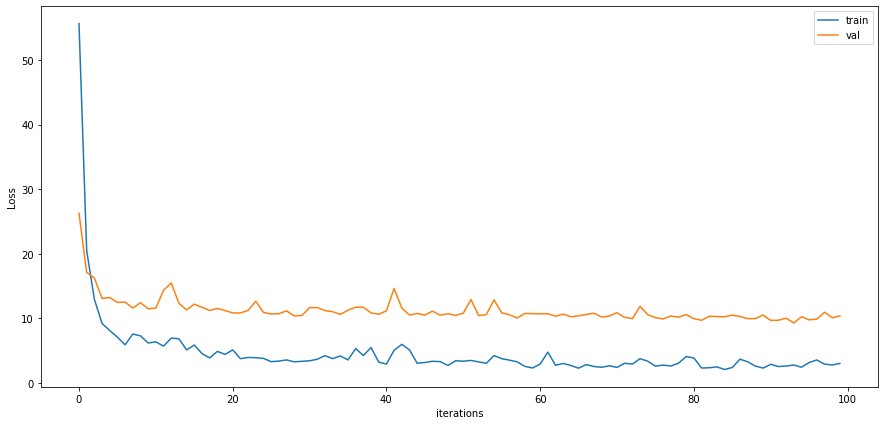

In [6]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()